In [115]:
from glob import glob
import numpy as np
from matplotlib import pylab as plt
import cv2
import tensorflow as tf
print(tf.__version__)
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
import time
import os
from keras.models import load_model

1.13.1


In [116]:
def load_data(batch_size):
    path1=sorted(glob('../input/building-photos/facade/test_picture/*'))
    path2=sorted(glob('../input/building-photos/facade/test_label/*'))
    i=np.random.randint(0,27)
    batch1=path1[i*batch_size:(i+1)*batch_size]
    batch2=path2[i*batch_size:(i+1)*batch_size]
    
    img_A=[]
    img_B=[]
    for filename1,filename2 in zip(batch1,batch2):
        img1=cv2.imread(filename1)
        img2=cv2.imread(filename2)
        img1=img1[...,::-1]
        img2=img2[...,::-1]
        img1=cv2.resize(img1,(256,256),interpolation=cv2.INTER_AREA)
        img2=cv2.resize(img2,(256,256),interpolation=cv2.INTER_AREA)
        img_A.append(img1)
        img_B.append(img2)
      
    img_A=np.array(img_A)/127.5-1
    img_B=np.array(img_B)/127.5-1
    
    return img_A,img_B 

In [117]:
def load_batch(batch_size):
    path1=sorted(glob('../input/building-photos/facade/train_picture/*'))
    path2=sorted(glob('../input/building-photos/facade/train_label/*'))
    n_batches=int(len(path1)/batch_size)
  
    for i in range(n_batches):
        batch1=path1[i*batch_size:(i+1)*batch_size]
        batch2=path2[i*batch_size:(i+1)*batch_size]
        img_A,img_B=[],[]
        for filename1,filename2 in zip(batch1,batch2):
            img1=cv2.imread(filename1)
            img2=cv2.imread(filename2)
            img1=img1[...,::-1]
            img2=img2[...,::-1]
            img1=cv2.resize(img1,(256,256),interpolation=cv2.INTER_AREA)    
            img2=cv2.resize(img2,(256,256),interpolation=cv2.INTER_AREA)
            img_A.append(img1)#picture
            img_B.append(img2)#label
      
        img_A=np.array(img_A)/127.5-1
        img_B=np.array(img_B)/127.5-1
    
        yield img_A,img_B #return generator

In [118]:
class pix2pix():
    def __init__(self):
        self.img_rows=256
        self.img_cols=256
        self.channels=3
        self.img_shape=(self.img_rows,self.img_cols,self.channels)
    
        patch=int(self.img_rows/(2**4)) # 16
        self.disc_patch=(patch,patch,1)
    
        self.gf=64
        self.df=64
    
        optimizer=tf.keras.optimizers.Adam(0.0002,0.5)
    
        self.discriminator=self.build_discriminator()
        #self.discriminator.summary()
        self.discriminator.compile(loss='binary_crossentropy',
                              optimizer=optimizer)
    
        self.generator=self.build_generator()
        #self.generator.summary()
    
        img_A=layers.Input(shape=self.img_shape)#picture--label
        img_B=layers.Input(shape=self.img_shape)#label--real
    
        img=self.generator(img_A)
    
        self.discriminator.trainable=False
    
        valid=self.discriminator([img,img_A])
    
        self.combined=Model(img_A,valid)
        self.combined.compile(loss='binary_crossentropy',
                              optimizer=optimizer)
    
    def build_generator(self):
        def conv2d(layer_input,filters,f_size=(4,4),bn=True):
            d=layers.Conv2D(filters,kernel_size=f_size,strides=(2,2),padding='same')(layer_input)
            d=layers.LeakyReLU(0.2)(d)
            if bn:
                d=layers.BatchNormalization()(d)
            return d
    
        def deconv2d(layer_input,skip_input,filters,f_size=(4,4),dropout_rate=0):
            u=layers.UpSampling2D((2,2))(layer_input)
            u=layers.Conv2D(filters,kernel_size=f_size,strides=(1,1),padding='same',activation='relu')(u)
            if dropout_rate:
                u=layers.Dropout(dropout_rate)(u)
            u=layers.BatchNormalization()(u)
            u=layers.Concatenate()([u,skip_input])
            return u
    
        d0=layers.Input(shape=self.img_shape)
    
        d1=conv2d(d0,self.gf,bn=False) 
        d2=conv2d(d1,self.gf*2)         
        d3=conv2d(d2,self.gf*4)         
        d4=conv2d(d3,self.gf*8)         
        d5=conv2d(d4,self.gf*8)         
        d6=conv2d(d5,self.gf*8)        
    
        d7=conv2d(d6,self.gf*8)         
    
        u1=deconv2d(d7,d6,self.gf*8,dropout_rate=0.5)   
        u2=deconv2d(u1,d5,self.gf*8,dropout_rate=0.5)   
        u3=deconv2d(u2,d4,self.gf*8,dropout_rate=0.5)   
        u4=deconv2d(u3,d3,self.gf*4)   
        u5=deconv2d(u4,d2,self.gf*2)   
        u6=deconv2d(u5,d1,self.gf)     
        u7=layers.UpSampling2D((2,2))(u6)
    
        output_img=layers.Conv2D(self.channels,kernel_size=(4,4),strides=(1,1),padding='same',activation='tanh')(u7)
    
        return Model(d0,output_img)
  
    def build_discriminator(self):
        def d_layer(layer_input,filters,f_size=(4,4),bn=True):
            d=layers.Conv2D(filters,kernel_size=f_size,strides=(2,2),padding='same')(layer_input)
            d=layers.LeakyReLU(0.2)(d)
            if bn:
                d=layers.BatchNormalization()(d)
            return d
    
        img_A=layers.Input(shape=self.img_shape)
        img_B=layers.Input(shape=self.img_shape)
    
        combined_imgs=layers.Concatenate(axis=-1)([img_A,img_B])
    
        d1=d_layer(combined_imgs,self.df,bn=False)
        d2=d_layer(d1,self.df*2)
        d3=d_layer(d2,self.df*4)
        d4=d_layer(d3,self.df*8)
    
        validity=layers.Conv2D(1,kernel_size=(4,4),strides=(1,1),padding='same',activation='sigmoid')(d4)
    
        return Model([img_A,img_B],validity)
  
    def train(self,epochs,batch_size=1):
        valid=np.ones((batch_size,)+self.disc_patch)
        fake=np.zeros((batch_size,)+self.disc_patch)
    
        for epoch in range(epochs):
            start=time.time()
            for batch_i,(img_A,img_B) in enumerate(load_batch(1)):
                gen_imgs=self.generator.predict(img_A)
        
                d_loss_real = self.discriminator.train_on_batch([img_B, img_A], valid)
                d_loss_fake = self.discriminator.train_on_batch([gen_imgs, img_A], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
                g_loss = self.combined.train_on_batch(img_A,valid)

                if batch_i % 50 == 0:
                    print ("[Epoch %d] [Batch %d] [D loss: %f] [G loss: %f]" % (epoch,
                                                                                batch_i,
                                                                                d_loss,
                                                                                g_loss))
            
            self.sample_images(epoch)
            print('Time for epoch {} is {} sec'.format(epoch,time.time()-start))
      
    def sample_images(self, epoch):
        r, c = 3, 3
        img_A, img_B =load_data(3)
        fake_A = self.generator.predict(img_A)

        gen_imgs = np.concatenate([img_A, fake_A, img_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i,j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./%d.png" % (epoch))
        plt.show()

    def input_images(self, path):
        img_A = []
        pix=cv2.imread(path)
        pix=pix[...,::-1]
        pix=cv2.resize(pix,(256,256),interpolation=cv2.INTER_AREA)
        img_A.append(pix)
        img_A=np.array(img_A)/127.5-1
        fake_A = self.generator.predict(img_A)

        gen_imgs = fake_A
        gen_imgs = 0.5 * gen_imgs + 0.5
        gen_imgs=gen_imgs.astype(np.int8)

        plt.imshow(gen_imgs)

    def input_img(self, path):
        img_A=[]
        img1=cv2.imread(path)
        img1=img1[...,::-1]
        img1=cv2.resize(img1,(256,256),interpolation=cv2.INTER_AREA)    
        img_A.append(img1)
        img_A=np.array(img_A)/127.5-1
        
        fake_A = self.generator.predict(img_A)

        gen_imgs = np.concatenate([fake_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig = plt.figure(figsize=(5,5))
        plt.imshow(gen_imgs[0])
        plt.axis('off')
        plt.show()
        #plt.savefig("../output/kaggle/working/test.png")

    
        
        

[Epoch 0] [Batch 0] [D loss: 1.410169] [G loss: 0.909154]
[Epoch 0] [Batch 50] [D loss: 0.689828] [G loss: 0.738021]
[Epoch 0] [Batch 100] [D loss: 0.789314] [G loss: 0.596308]
[Epoch 0] [Batch 150] [D loss: 0.260784] [G loss: 0.491389]
[Epoch 0] [Batch 200] [D loss: 0.165217] [G loss: 0.416474]
[Epoch 0] [Batch 250] [D loss: 0.135685] [G loss: 0.022648]
[Epoch 0] [Batch 300] [D loss: 0.008313] [G loss: 0.006590]
[Epoch 0] [Batch 350] [D loss: 0.167219] [G loss: 0.147486]
[Epoch 0] [Batch 400] [D loss: 0.016485] [G loss: 0.016832]
[Epoch 0] [Batch 450] [D loss: 0.021233] [G loss: 0.121236]
[Epoch 0] [Batch 500] [D loss: 0.141265] [G loss: 0.078285]


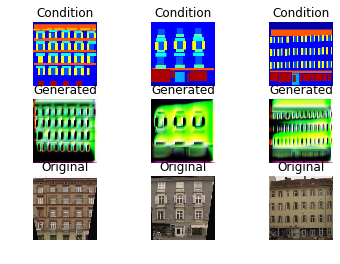

Time for epoch 0 is 226.840678691864 sec
[Epoch 1] [Batch 0] [D loss: 0.086835] [G loss: 2.069565]
[Epoch 1] [Batch 50] [D loss: 0.561464] [G loss: 2.847235]
[Epoch 1] [Batch 100] [D loss: 0.449438] [G loss: 1.795388]
[Epoch 1] [Batch 150] [D loss: 0.327279] [G loss: 2.782804]
[Epoch 1] [Batch 200] [D loss: 0.230746] [G loss: 0.045274]
[Epoch 1] [Batch 250] [D loss: 0.532876] [G loss: 0.785137]
[Epoch 1] [Batch 300] [D loss: 0.478872] [G loss: 0.960421]
[Epoch 1] [Batch 350] [D loss: 0.285291] [G loss: 0.803667]
[Epoch 1] [Batch 400] [D loss: 0.020971] [G loss: 0.101764]
[Epoch 1] [Batch 450] [D loss: 0.476208] [G loss: 0.321442]
[Epoch 1] [Batch 500] [D loss: 0.132831] [G loss: 0.160945]


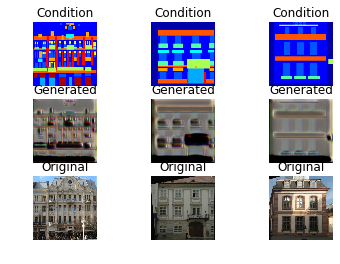

Time for epoch 1 is 88.4199230670929 sec
[Epoch 2] [Batch 0] [D loss: 1.663826] [G loss: 0.288602]
[Epoch 2] [Batch 50] [D loss: 0.162529] [G loss: 0.219421]
[Epoch 2] [Batch 100] [D loss: 0.071686] [G loss: 0.055985]
[Epoch 2] [Batch 150] [D loss: 0.240181] [G loss: 0.430349]
[Epoch 2] [Batch 200] [D loss: 0.060520] [G loss: 0.035247]
[Epoch 2] [Batch 250] [D loss: 0.079228] [G loss: 0.073828]
[Epoch 2] [Batch 300] [D loss: 0.071214] [G loss: 0.851589]
[Epoch 2] [Batch 350] [D loss: 0.256825] [G loss: 1.404101]
[Epoch 2] [Batch 400] [D loss: 0.023577] [G loss: 0.023728]
[Epoch 2] [Batch 450] [D loss: 0.236224] [G loss: 1.414981]
[Epoch 2] [Batch 500] [D loss: 0.035778] [G loss: 0.011357]


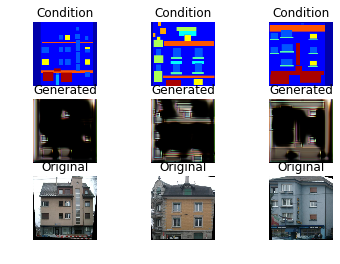

Time for epoch 2 is 88.69195985794067 sec
[Epoch 3] [Batch 0] [D loss: 0.025069] [G loss: 0.028925]
[Epoch 3] [Batch 50] [D loss: 0.148362] [G loss: 0.488222]
[Epoch 3] [Batch 100] [D loss: 0.115881] [G loss: 1.446948]
[Epoch 3] [Batch 150] [D loss: 0.082892] [G loss: 0.417297]
[Epoch 3] [Batch 200] [D loss: 1.047269] [G loss: 0.026006]
[Epoch 3] [Batch 250] [D loss: 0.103563] [G loss: 0.669429]
[Epoch 3] [Batch 300] [D loss: 0.275927] [G loss: 2.375197]
[Epoch 3] [Batch 350] [D loss: 0.307152] [G loss: 0.010519]
[Epoch 3] [Batch 400] [D loss: 0.006225] [G loss: 0.009653]
[Epoch 3] [Batch 450] [D loss: 0.273004] [G loss: 0.056258]
[Epoch 3] [Batch 500] [D loss: 0.040170] [G loss: 0.003570]


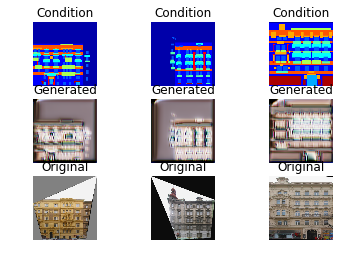

Time for epoch 3 is 89.10740423202515 sec
[Epoch 4] [Batch 0] [D loss: 0.005068] [G loss: 0.002003]
[Epoch 4] [Batch 50] [D loss: 0.923583] [G loss: 0.316260]
[Epoch 4] [Batch 100] [D loss: 0.086238] [G loss: 0.013435]
[Epoch 4] [Batch 150] [D loss: 0.026129] [G loss: 0.009289]
[Epoch 4] [Batch 200] [D loss: 0.239163] [G loss: 0.013946]
[Epoch 4] [Batch 250] [D loss: 0.260827] [G loss: 3.751185]
[Epoch 4] [Batch 300] [D loss: 0.009444] [G loss: 0.017825]
[Epoch 4] [Batch 350] [D loss: 0.621397] [G loss: 1.405328]
[Epoch 4] [Batch 400] [D loss: 0.002516] [G loss: 0.005934]
[Epoch 4] [Batch 450] [D loss: 0.733791] [G loss: 0.195651]
[Epoch 4] [Batch 500] [D loss: 0.029530] [G loss: 0.062269]


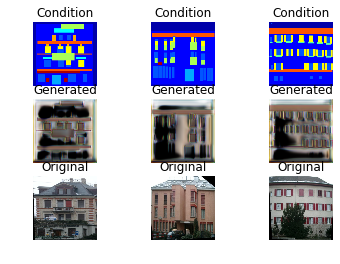

Time for epoch 4 is 89.35936999320984 sec
[Epoch 5] [Batch 0] [D loss: 0.747152] [G loss: 1.507350]
[Epoch 5] [Batch 50] [D loss: 0.076049] [G loss: 0.035142]
[Epoch 5] [Batch 100] [D loss: 1.166823] [G loss: 0.042437]
[Epoch 5] [Batch 150] [D loss: 0.020424] [G loss: 0.007001]
[Epoch 5] [Batch 200] [D loss: 0.587285] [G loss: 0.008487]
[Epoch 5] [Batch 250] [D loss: 0.015917] [G loss: 0.032029]
[Epoch 5] [Batch 300] [D loss: 0.007083] [G loss: 0.042586]
[Epoch 5] [Batch 350] [D loss: 0.056241] [G loss: 0.026131]
[Epoch 5] [Batch 400] [D loss: 0.533355] [G loss: 0.115330]
[Epoch 5] [Batch 450] [D loss: 0.140596] [G loss: 0.011905]
[Epoch 5] [Batch 500] [D loss: 0.024740] [G loss: 0.011124]


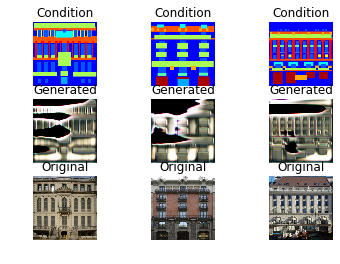

Time for epoch 5 is 88.69789862632751 sec
[Epoch 6] [Batch 0] [D loss: 0.123842] [G loss: 0.003214]
[Epoch 6] [Batch 50] [D loss: 0.008769] [G loss: 0.013985]
[Epoch 6] [Batch 100] [D loss: 0.090506] [G loss: 0.373833]
[Epoch 6] [Batch 150] [D loss: 0.006759] [G loss: 0.027774]
[Epoch 6] [Batch 200] [D loss: 1.758390] [G loss: 1.758600]
[Epoch 6] [Batch 250] [D loss: 0.249158] [G loss: 0.036375]
[Epoch 6] [Batch 300] [D loss: 0.136119] [G loss: 0.033460]
[Epoch 6] [Batch 350] [D loss: 1.494179] [G loss: 1.048863]
[Epoch 6] [Batch 400] [D loss: 0.003054] [G loss: 0.011554]
[Epoch 6] [Batch 450] [D loss: 0.068964] [G loss: 0.246746]
[Epoch 6] [Batch 500] [D loss: 0.006316] [G loss: 0.044128]


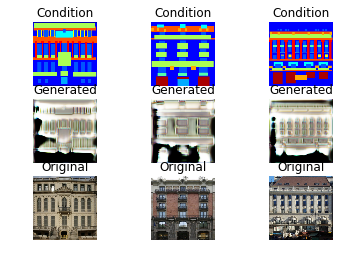

Time for epoch 6 is 88.87325716018677 sec
[Epoch 7] [Batch 0] [D loss: 1.110042] [G loss: 1.094620]
[Epoch 7] [Batch 50] [D loss: 0.348577] [G loss: 0.016255]
[Epoch 7] [Batch 100] [D loss: 0.138129] [G loss: 0.019852]
[Epoch 7] [Batch 150] [D loss: 0.315293] [G loss: 0.044807]
[Epoch 7] [Batch 200] [D loss: 1.025474] [G loss: 0.086790]
[Epoch 7] [Batch 250] [D loss: 0.171094] [G loss: 1.726113]
[Epoch 7] [Batch 300] [D loss: 0.512278] [G loss: 0.045931]
[Epoch 7] [Batch 350] [D loss: 0.090487] [G loss: 0.010491]
[Epoch 7] [Batch 400] [D loss: 0.006945] [G loss: 0.009540]
[Epoch 7] [Batch 450] [D loss: 0.047443] [G loss: 0.039077]
[Epoch 7] [Batch 500] [D loss: 0.017390] [G loss: 0.002357]


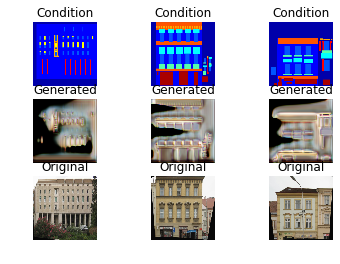

Time for epoch 7 is 89.07113790512085 sec
[Epoch 8] [Batch 0] [D loss: 1.686850] [G loss: 0.056292]
[Epoch 8] [Batch 50] [D loss: 0.206310] [G loss: 0.213790]
[Epoch 8] [Batch 100] [D loss: 0.424395] [G loss: 1.384332]
[Epoch 8] [Batch 150] [D loss: 0.006244] [G loss: 0.056690]
[Epoch 8] [Batch 200] [D loss: 0.931865] [G loss: 1.873125]
[Epoch 8] [Batch 250] [D loss: 0.004732] [G loss: 0.001169]
[Epoch 8] [Batch 300] [D loss: 0.004152] [G loss: 0.021937]
[Epoch 8] [Batch 350] [D loss: 0.012368] [G loss: 0.006111]
[Epoch 8] [Batch 400] [D loss: 0.003762] [G loss: 0.004772]
[Epoch 8] [Batch 450] [D loss: 0.018774] [G loss: 0.011773]
[Epoch 8] [Batch 500] [D loss: 0.101973] [G loss: 0.273698]


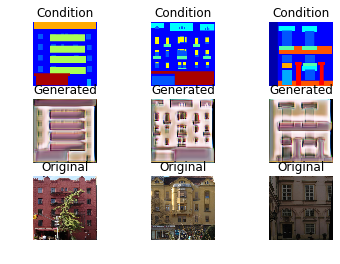

Time for epoch 8 is 88.93365263938904 sec
[Epoch 9] [Batch 0] [D loss: 0.156324] [G loss: 0.728988]
[Epoch 9] [Batch 50] [D loss: 0.842482] [G loss: 0.546673]
[Epoch 9] [Batch 100] [D loss: 0.226507] [G loss: 0.135819]
[Epoch 9] [Batch 150] [D loss: 0.643740] [G loss: 6.400375]
[Epoch 9] [Batch 200] [D loss: 0.050683] [G loss: 0.010508]
[Epoch 9] [Batch 250] [D loss: 0.096074] [G loss: 0.006047]
[Epoch 9] [Batch 300] [D loss: 0.128967] [G loss: 0.301710]
[Epoch 9] [Batch 350] [D loss: 0.047521] [G loss: 0.020566]
[Epoch 9] [Batch 400] [D loss: 0.001718] [G loss: 0.095777]
[Epoch 9] [Batch 450] [D loss: 0.067780] [G loss: 0.472568]
[Epoch 9] [Batch 500] [D loss: 0.053908] [G loss: 0.005411]


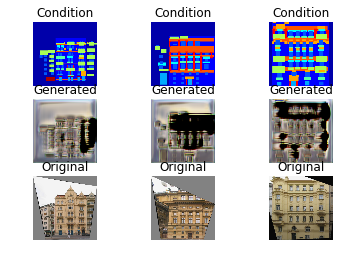

Time for epoch 9 is 99.14975953102112 sec


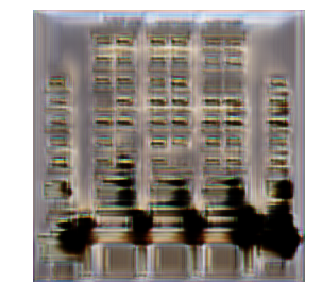

In [119]:
if __name__ == '__main__':
    gan = pix2pix()
    gan.train(epochs=500, batch_size=1)
    #gan.generator.save('../output/kaggle/working/my_model.h5')
    #gan.generator = load_model('../output/kaggle/working/my_model.h5')
    gan.input_img('../input/building-photos/facade/train_picture/cmp_b0001.png')
    